In [28]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from nanowire.optics.simulate import Simulator
from nanowire.optics.utils.utils import setup_sim
from nanowire.optics.utils.config import Config

# Introduction

This is just a quick test to determine if these cells actually have periodic BC's, and whether or not S4
includes both edges when using `GetFieldsOnPlane` (i.e x = 0 and x = period), or whether it excludes data at
x = period.

# Shifted Nanowire

In [29]:
conf = Config('PeriodicBCTest.yml')
sim = Simulator(conf)
sim = setup_sim(sim)

## ITO

In [30]:
num_samples = 100
Explane, Eyplane, Ezplane, Hx, Hy, Hz = sim.compute_fields_on_plane(.6, num_samples, num_samples)

#########################
Examining Ex component
Testing x=0 and x=period
Testing y=0 and y=period
#########################
Examining Ey component
Testing x=0 and x=period


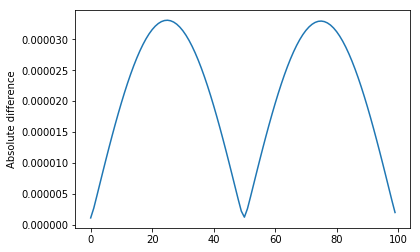

Testing y=0 and y=period


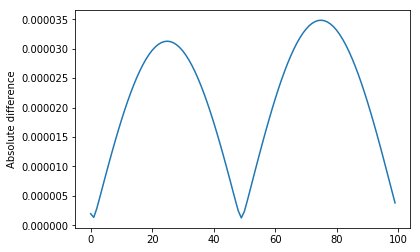

#########################
Examining Ez component
Testing x=0 and x=period
Testing y=0 and y=period


In [31]:
compstrs = ("Ex", "Ey", "Ez")
for i, component in enumerate((Explane, Eyplane, Ezplane)):
    print("#"*25)
    print("Examining {} component".format(compstrs[i]))
    print('Testing x=0 and x=period')
    try:
        assert np.all(np.isclose(component[:, -1], component[:, 0]))
    except AssertionError:
        print('WARNING: Not periodic!')
        diff = np.absolute(component[:, -1] - component[:, 0])
        plt.figure()
        plt.plot(diff)
        plt.ylabel('Absolute difference')
        plt.show()
    print('Testing y=0 and y=period')
    try:
        assert np.all(np.isclose(component[-1, :], component[0, :]))
    except AssertionError:
        print('WARNING: Not periodic!')
        diff = np.absolute(component[-1, :] - component[0, :])
        plt.figure()
        plt.plot(diff)
        plt.ylabel('Absolute difference')
        plt.show()

So these are not periodic. This could be because S4 excludes x=period when taking data at i=100
(think np.arange, or linspace with endpoint=False) so we haven't actually reached the periodic BC. Lets try explicitly getting the correct positions using `GetFieldsAtPoint` and see if data when x=0 and x=period are the same

In [32]:
vals = np.linspace(0, sim.period, 100)
xofields = 0j*np.zeros((len(vals), 3))
xpfields = 0j*np.zeros((len(vals), 3))
for i, val in enumerate(vals):
    xofield, H = sim.compute_fields_at_point(0, val, .6)
    xpfield, H = sim.compute_fields_at_point(sim.period, val, .6)
    xofields[i, 0] = xofield[0]
    xofields[i, 1] = xofield[1]
    xofields[i, 2] = xofield[2]
    xpfields[i, 0] = xpfield[0]
    xpfields[i, 1] = xpfield[1]
    xpfields[i, 2] = xpfield[2]

`np.isclose` compares fields elementwise and is True if the elements are the same within a tolerance, False
otherwise. `np.all` makes sure all elements are True. First column is x component of fields, second column y 
component, third column z component.

In [33]:
diff = np.absolute(xofields - xpfields)
assert np.all(np.isclose(xofields, xpfields))
#print(diff)

So these seem periodic! This is good news. Double checking in the y direction just in case.

In [34]:
vals = np.linspace(0, sim.period, 100)
xofields = 0j*np.zeros((len(vals), 3))
xpfields = 0j*np.zeros((len(vals), 3))
for i, val in enumerate(vals):
    xofield, H = sim.compute_fields_at_point(val, 0, .6)
    xpfield, H = sim.compute_fields_at_point(val, sim.period, .6)
    xofields[i, 0] = xofield[0]
    xofields[i, 1] = xofield[1]
    xofields[i, 2] = xofield[2]
    xpfields[i, 0] = xpfield[0]
    xpfields[i, 1] = xpfield[1]
    xpfields[i, 2] = xpfield[2]
diff = np.absolute(xofields - xpfields)
assert np.all(np.isclose(xofields, xpfields))
#print(diff)

Good, so we know things are periodic! In this case, the last column of values from `GetFieldsOnPlane` should be 
equal to the fields returned by `GetFieldsAtPoint` with y=period-dy. I verify this below

In [35]:
(ex, ey, ez), H = sim.compute_fields_at_point(0, 0, 0.6)
Ex = Explane[0, 0]
Ey = Eyplane[0, 0]
Ez = Ezplane[0, 0]
print(ex - Ex)
print(ey - Ey)
print(ez - Ez)
print(ez)
print(Ez)

(-1.11022302463e-15+1.11022302463e-16j)
4.33680868994e-19j
(-7.5663395081e-05-1.81275977104e-05j)
(-7.566333804763854e-05-1.8127596327531786e-05j)
(5.70333994747e-11+1.38287769366e-12j)


[  9.379e-05 -5.754e-05j   5.467e-04 -1.065e-04j   9.974e-04 -1.552e-04j
   1.444e-03 -2.035e-04j   1.885e-03 -2.512e-04j   2.319e-03 -2.982e-04j
   2.744e-03 -3.442e-04j   3.157e-03 -3.891e-04j   3.559e-03 -4.326e-04j
   3.946e-03 -4.747e-04j   4.318e-03 -5.151e-04j   4.673e-03 -5.537e-04j
   5.009e-03 -5.904e-04j   5.326e-03 -6.249e-04j   5.622e-03 -6.572e-04j
   5.895e-03 -6.871e-04j   6.146e-03 -7.145e-04j   6.372e-03 -7.394e-04j
   6.573e-03 -7.615e-04j   6.748e-03 -7.809e-04j   6.897e-03 -7.974e-04j
   7.018e-03 -8.109e-04j   7.112e-03 -8.215e-04j   7.177e-03 -8.291e-04j
   7.215e-03 -8.336e-04j   7.224e-03 -8.350e-04j   7.204e-03 -8.334e-04j
   7.156e-03 -8.287e-04j   7.080e-03 -8.209e-04j   6.976e-03 -8.101e-04j
   6.844e-03 -7.963e-04j   6.685e-03 -7.796e-04j   6.500e-03 -7.600e-04j
   6.289e-03 -7.377e-04j   6.054e-03 -7.126e-04j   5.794e-03 -6.850e-04j
   5.512e-03 -6.548e-04j   5.208e-03 -6.223e-04j   4.883e-03 -5.875e-04j
   4.539e-03 -5.506e-04j   4.177e-03 -5.118e-04j   

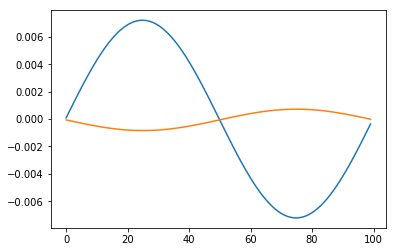

AssertionError: 

In [23]:
dy = sim.period/num_samples
# This excludes x=period
yvals = np.arange(0, sim.period, dy)
Expoint = 0j*np.zeros((len(vals),))
Eypoint = 0j*np.zeros((len(vals),))
Ezpoint = 0j*np.zeros((len(vals),))
for i, val in enumerate(yvals):
    #ex, ey, ez = sim.compute_fields_at_point(val, sim.period-dy, .6)
    (ex, ey, ez), H = sim.compute_fields_at_point(val, 0, .6)
    Expoint[i] = ex
    Eypoint[i] = ey
    Ezpoint[i] = ez
xdiff = Explane[:, -1] - Expoint
ydiff = Eyplane[:, -1] - Eypoint
zdiff = Ezplane[:, -1] - Ezpoint
assert np.all(np.isclose(Expoint, Explane[:, 0]))
assert np.all(np.isclose(Eypoint, Eyplane[:, 0]))
print(zdiff)
plt.figure()
plt.plot(zdiff.real)
plt.plot(zdiff.imag)
plt.show()
assert np.all(np.isclose(Ezpoint, Ezplane[:, 0]))

So strangely, the x and y components of the E field pass this test. The z component of the field does not! This 
seems like a bug in S4 somewhere, either in S4 itself or in the Python interface. Not sure I have the time or desire
to debug this further, and may just stop using the `GetFieldsOnPlane` function. The problem with this is that the
`GetFieldAtPoint` function is much less efficient, and will probably be considerably slower. I test this claim
below.

In [16]:
def test_by_point(sim, z, xsamp, ysamp):
    dx = sim.period/xsamp
    dy = sim.period/ysamp
    Ex = 0j*np.zeros((xsamp, ysamp))
    Ey = 0j*np.zeros((xsamp, ysamp))
    Ez = 0j*np.zeros((xsamp, ysamp))
    xcoords = np.arange(0, sim.period, dx)
    ycoords = np.arange(0, sim.period, dy)
    for i, x in enumerate(xcoords):
        for j, y in enumerate(ycoords):
            E = sim.compute_fields_at_point(x, y, z) 
            Ex[i, j] = E[0]
            Ey[i, j] = E[1]
            Ez[i, j] = E[2]
    return (Ex, Ey, Ez)


def test_by_point_vec(sim, z, xsamp, ysamp):
    dx = sim.period/xsamp
    dy = sim.period/ysamp
    Ex = 0j*np.zeros((xsamp, ysamp))
    Ey = 0j*np.zeros((xsamp, ysamp))
    Ez = 0j*np.zeros((xsamp, ysamp))
    xcoords = np.arange(0, sim.period, dx)
    ycoords = np.arange(0, sim.period, dy)
    xx, yy = np.meshgrid(xcoords, ycoords)
    test = np.vectorize(sim.compute_fields_at_point)
    return test(xx, yy, z)

In [19]:
print("#"*30)
print('By point timing:')
pointres = %timeit -o test_by_point(sim, .6, 100, 100)
print("#"*30)
print('Vectorized point timing:')
pointres = %timeit -o test_by_point_vec(sim, .6, 100, 100)
print("#"*30)
print('Plane timing:')
planeres = %timeit -o sim.compute_fields_on_plane(.6, 100, 100)
frac = int(round(pointres.average/planeres.average))

##############################
By point timing:
545 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
##############################
Vectorized point timing:
535 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
##############################
Plane timing:
8.83 ms ± 410 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So getting fields by point definitely takes way longer, about {{frac}} times longer. Vectorizing it doesn't seem
to help at all, but the documentation for `np.vectorize` basically says its intended for convenience and not
performance so it was a bit of a long shot anyway. Let's compare the results to make sure we're actually getting the
same data from the two methods

In [20]:
Epoint = test_by_point(sim, .6, 100, 100)
Eplane = sim.compute_fields_on_plane(.6, 100, 100)
print('Done!')

Done!


In [21]:
comps = ('Ex', 'Ey', 'Ez')
for i in range(len(Epoint)):
    diff = np.absolute(Epoint[i] - Eplane[i])
    try:
        assert np.all(np.isclose(Epoint[i], Eplane[i])) 
    except AssertionError:
        print("{} component not the same!".format(comps[i]))
        print(diff)

Ez component not the same!
[[ 0.00113814  0.00598005  0.01117372 ...,  0.01504925  0.00987104
   0.00468736]
 [ 0.00621394  0.00855226  0.01274142 ...,  0.01624331  0.01160836
   0.0076987 ]
 [ 0.01142403  0.01285029  0.01595482 ...,  0.01887274  0.01506086
   0.0122962 ]
 ..., 
 [ 0.01476847  0.01589455  0.01849678 ...,  0.02110258  0.01775433
   0.01546218]
 [ 0.0095801   0.01123559  0.0146789  ...,  0.01783184  0.01372654
   0.01061217]
 [ 0.00437248  0.00731844  0.01194396 ...,  0.0156407   0.01074389
   0.00631329]]


So the z-component is different between the two methods! This is totally messed up! Maybe there is some constant
shift in the z direction. 

In [22]:
Epoint = test_by_point(sim, .6, 100, 100)
Eplane = sim.compute_fields_on_plane(.5, 100, 100)
diff = np.absolute(Epoint[2] - Eplane[2])
print(diff)

[[ 0.00093014  0.00487235  0.00910261 ...,  0.01225752  0.00803976
   0.0038178 ]
 [ 0.0050647   0.00696926  0.01038131 ...,  0.01323193  0.00945685
   0.00627304]
 [ 0.00930846  0.01047074  0.01300031 ...,  0.01537631  0.01227087
   0.01001871]
 ..., 
 [ 0.01202637  0.01294496  0.01506691 ...,  0.01719054  0.01446071
   0.01259181]
 [ 0.00780025  0.00915005  0.01195644 ...,  0.01452468  0.01117927
   0.00864115]
 [ 0.00355854  0.00596012  0.00972881 ...,  0.01273891  0.00874965
   0.00513977]]


So that seems to have made a difference. I'll try doing a sweep through z values until I find the one that passes
this assertion test

In [26]:
dz = .001
for z in np.arange(.3, .9, dz):
    Eplane = sim.compute_fields_on_plane(z, 100, 100)
    diff = np.absolute(Epoint[2] - Eplane[2])
    print("#"*30)
    print("z shift = {}".format(.6-z))
    print('Max Difference: {}'.format(np.amax(diff)))
    print('Max Difference Loc: {}'.format(np.argmax(diff)))
    try:
        assert np.all(np.isclose(Epoint[2], Eplane[2])) 
    except AssertionError:
        continue
    print('Equal at {}'.format(z))
    break

##############################
z shift = 0.3
Max Difference: 0.12983653687401722
Max Difference Loc: 7473
##############################
z shift = 0.299
Max Difference: 0.12983182046574449
Max Difference Loc: 7473
##############################
z shift = 0.298
Max Difference: 0.12982699095314368
Max Difference Loc: 7473
##############################
z shift = 0.297
Max Difference: 0.12982204562360444
Max Difference Loc: 7473
##############################
z shift = 0.296
Max Difference: 0.12981698169945022
Max Difference Loc: 7473
##############################
z shift = 0.295
Max Difference: 0.1298117963363774
Max Difference Loc: 7473
##############################
z shift = 0.294
Max Difference: 0.12980648662185681
Max Difference Loc: 7473
##############################
z shift = 0.293
Max Difference: 0.12980104957349675
Max Difference Loc: 7473
##############################
z shift = 0.292
Max Difference: 0.12979548213736705
Max Difference Loc: 7473
##############################


So the maximum difference is always in the same place regardless of the shift in the z direction. Once we cross
into the air layer at shifts greater than -.1 the location changes, but thats to be expected. So shifting doesn't
fix anything.
I'm a bit stumped here. It seems like getting the fields at each individual point is correct, because the boundary
conditions are actually periodic. This is all making me a bit concerned about S4 as a whole though. I might need to
dig into the source and figure out what is going on here. I check this all in the nanowire layer as well

## Nanowire

In [35]:
num_samples = 100
Explane, Eyplane, Ezplane = sim.compute_fields_on_plane(1.0, num_samples, num_samples)

Testing x=0 and x=period


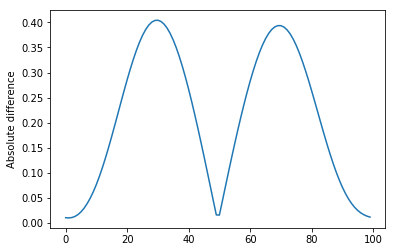

Testing y=0 and y=period


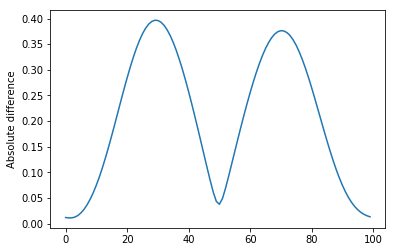

Testing x=0 and x=period


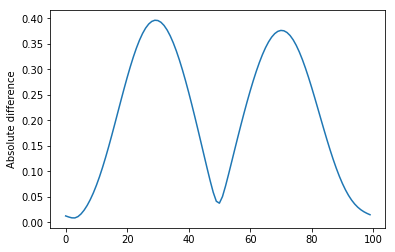

Testing y=0 and y=period


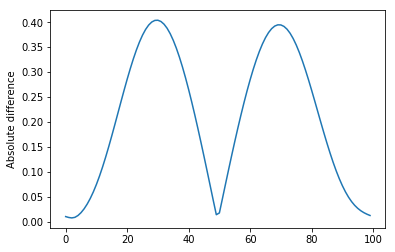

Testing x=0 and x=period


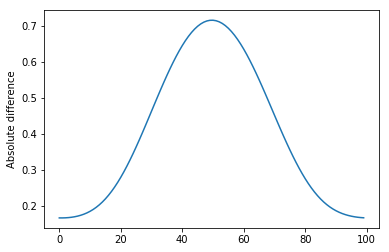

Testing y=0 and y=period


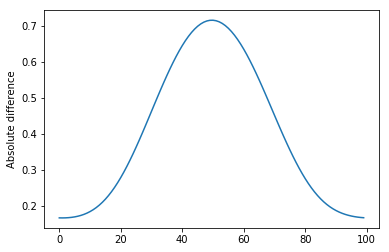

In [36]:
comps = ('Ex', 'Ey', 'Ez')
for i, component in enumerate((Explane, Eyplane, Ezplane)):
    print('Testing x=0 and x=period')
    try:
        assert np.all(np.isclose(component[:, -1], component[:, 0]))
    except AssertionError:
        print('WARNING: {} component not periodic!'.format(comps[i]))
        diff = np.absolute(component[:, -1] - component[:, 0])
        plt.figure()
        plt.plot(diff)
        plt.ylabel('Absolute difference')
        plt.show()
    print('Testing y=0 and y=period')
    try:
        assert np.all(np.isclose(component[:, -1], component[:, 0]))
    except AssertionError:
        print('WARNING: {} component not periodic!'.format(comps[i]))
        diff = np.absolute(component[-1, :] - component[0, :])
        plt.figure()
        plt.plot(diff)
        plt.ylabel('Absolute difference')
        plt.show()

In [37]:
vals = np.linspace(0, sim.period, 100)
xofields = 0j*np.zeros((len(vals), 3))
xpfields = 0j*np.zeros((len(vals), 3))
for i, val in enumerate(vals):
    xofield = sim.compute_fields_at_point(0, val, 1.0)
    xpfield = sim.compute_fields_at_point(sim.period, val, 1.0)
    xofields[i, 0] = xofield[0]
    xofields[i, 1] = xofield[1]
    xofields[i, 2] = xofield[2]
    xpfields[i, 0] = xpfield[0]
    xpfields[i, 1] = xpfield[1]
    xpfields[i, 2] = xpfield[2]
diff = np.absolute(xofields - xpfields)
assert np.all(np.isclose(xofields, xpfields))
print(diff)

[[  2.51214793e-15   4.72073305e-15   8.39118578e-16]
 [  3.58036167e-15   3.99680289e-15   1.32561934e-15]
 [  4.44089210e-16   1.33226763e-15   2.26105750e-15]
 [  8.88178420e-16   4.44089210e-16   1.66625947e-15]
 [  3.79429987e-15   1.77635684e-15   1.33688556e-15]
 [  1.98602732e-15   2.84355838e-15   1.11576033e-15]
 [  4.44089210e-16   1.77635684e-15   2.84572490e-15]
 [  1.83102672e-15   1.77635684e-15   1.06633439e-15]
 [  1.83102672e-15   4.44089210e-16   1.27675648e-15]
 [  3.55271368e-15   2.22044605e-15   1.97669590e-15]
 [  1.83102672e-15   4.44089210e-16   1.11022302e-15]
 [  3.20237283e-15   1.33226763e-15   7.02166694e-16]
 [  3.58036167e-15   3.58036167e-15   1.24126708e-15]
 [  3.66205344e-15   5.61733355e-15   2.92054080e-15]
 [  1.98602732e-15   2.22044605e-15   1.60118642e-15]
 [  3.55271368e-15   8.88178420e-16   1.89714994e-15]
 [  1.98602732e-15   2.84355838e-15   1.25607397e-15]
 [  3.20237283e-15   4.18952923e-15   1.18018326e-15]
 [  8.88178420e-16   3.99680

In [38]:
vals = np.linspace(0, sim.period, 100)
xofields = 0j*np.zeros((len(vals), 3))
xpfields = 0j*np.zeros((len(vals), 3))
for i, val in enumerate(vals):
    xofield = sim.compute_fields_at_point(val, 0, 1.0)
    xpfield = sim.compute_fields_at_point(val, sim.period, 1.0)
    xofields[i, 0] = xofield[0]
    xofields[i, 1] = xofield[1]
    xofields[i, 2] = xofield[2]
    xpfields[i, 0] = xpfield[0]
    xpfields[i, 1] = xpfield[1]
    xpfields[i, 2] = xpfield[2]
diff = np.absolute(xofields - xpfields)
assert np.all(np.isclose(xofields, xpfields))
print(diff)

[[  1.83102672e-15   1.77635684e-15   7.35522754e-16]
 [  5.49308016e-15   3.58036167e-15   3.08099392e-15]
 [  4.44089210e-16   3.79429987e-15   1.41526222e-15]
 [  2.84355838e-15   3.97205465e-15   7.02166694e-16]
 [  3.97205465e-15   3.58036167e-15   7.79136136e-16]
 [  2.22044605e-15   3.20237283e-15   3.00222453e-15]
 [  3.79429987e-15   3.55271368e-15   1.71366799e-15]
 [  4.44089210e-16   1.83102672e-15   9.48574968e-16]
 [  1.77635684e-15   4.44089210e-16   1.19574679e-15]
 [  1.98602732e-15   1.77635684e-15   1.57009246e-15]
 [  1.83102672e-15   3.97205465e-15   1.33688556e-15]
 [  2.22044605e-15   2.22044605e-15   9.15513360e-16]
 [  4.72073305e-15   1.98602732e-15   4.96506831e-16]
 [  4.44089210e-16   5.49308016e-15   2.39149358e-15]
 [  1.98602732e-15   1.77635684e-15   1.58959746e-15]
 [  2.51214793e-15   4.18952923e-15   1.66533454e-15]
 [  1.33226763e-15   1.77635684e-15   5.55111512e-16]
 [  4.44089210e-16   1.77635684e-15   7.77156117e-16]
 [  8.88178420e-16   3.66205

[  1.80411242e-16 -4.02455846e-16j  -1.02001740e-15 -2.77555756e-15j
  -5.27355937e-16 +2.77555756e-16j  -4.44089210e-16 -4.44089210e-16j
  -3.33066907e-16 +1.66533454e-15j   8.60422844e-16 +6.66133815e-16j
   5.55111512e-17 -1.55431223e-15j  -4.99600361e-16 +0.00000000e+00j
   2.22044605e-16 -1.77635684e-15j  -5.55111512e-17 +1.99840144e-15j
   4.44089210e-16 -6.66133815e-16j  -1.33226763e-15 -1.77635684e-15j
  -6.66133815e-16 +1.33226763e-15j  -4.44089210e-16 -2.22044605e-16j
  -8.88178420e-16 +0.00000000e+00j  -4.44089210e-16 -8.88178420e-16j
  -1.33226763e-15 -2.22044605e-15j  -1.33226763e-15 +4.44089210e-16j
   4.44089210e-16 -1.77635684e-15j   6.66133815e-16 +4.44089210e-16j
  -4.44089210e-16 +3.10862447e-15j  -2.44249065e-15 +8.88178420e-16j
  -1.33226763e-15 +3.10862447e-15j  -1.55431223e-15 +8.88178420e-16j
  -1.33226763e-15 +2.22044605e-15j  -1.88737914e-15 +1.33226763e-15j
  -2.22044605e-15 +4.44089210e-16j  -1.44328993e-15 +3.99680289e-15j
  -8.88178420e-16 +4.44089210e-16j

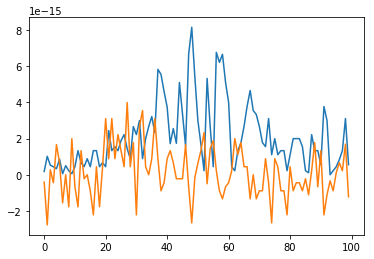

In [39]:
dy = sim.period/num_samples
# This excludes x=period
yvals = np.arange(0, sim.period, dy)
Expoint = 0j*np.zeros((len(vals),))
Eypoint = 0j*np.zeros((len(vals),))
Ezpoint = 0j*np.zeros((len(vals),))
for i, val in enumerate(yvals):
    ex, ey, ez = sim.compute_fields_at_point(val, sim.period-dy, 1.0)
    Expoint[i] = ex
    Eypoint[i] = ey
    Ezpoint[i] = ez
xdiff = Explane[:, -1] - Expoint
ydiff = Eyplane[:, -1] - Eypoint
zdiff = Ezplane[:, -1] - Ezpoint
assert np.all(np.isclose(Expoint, Explane[:, -1]))
assert np.all(np.isclose(Eypoint, Eyplane[:, -1]))
print(zdiff)
plt.figure()
plt.plot(abs(zdiff.real))
plt.plot(zdiff.imag)
plt.show()
assert np.all(np.isclose(Ezpoint, Ezplane[:, -1]))

So in the nanowire layer everything checks out! The x, y, and z components of the fields at y=period-dy using 
`GetFieldsAtPoint` are equal to the last column of the the fields returned by `GetFieldsOnPlane` in the nanowire
layer. So `GetFieldsOnPlane` is appropriately periodic and the two methods agree! This definitely smells like a bug
somewhere, because things make sense physically in one layer but not the other.

In [40]:
Epoint = test_by_point(sim, 1.0, 100, 100)
Eplane = sim.compute_fields_on_plane(1.0, 100, 100)
print('Done!')

Done!


In [42]:
comps = ('Ex', 'Ey', 'Ez')
for i in range(len(Epoint)):
    diff = np.absolute(Epoint[i] - Eplane[i])
    try:
        assert np.all(np.isclose(Epoint[i], Eplane[i])) 
    except AssertionError:
        print("{} component not the same!".format(comps[i]))
        print(diff)
        raise
print('All components agree!')

All components agree!


So the two methods fully agree in the nanowire layer, but do not in the ITO layer. So there seems to be a serious 
issue with mixing patterned and unpatterned layers and computing the fields. Which method is correct remains to be
conclusively determined, I'll need to compare to some external source of truth to be absolutely sure (my hunch is
that `GetFieldsAtPoint` is correct, because periodic BCs and Murphy's law). In the next section I just check to make
sure shifting the unit cell doesn't make a difference.

# Centered Nanowire

In [43]:
conf = Config('PeriodicBCTest_centered.yml')
sim = Simulator(conf)
sim = setup_sim(sim)

## ITO

In [44]:
num_samples = 100
Explane, Eyplane, Ezplane = sim.compute_fields_on_plane(.6, num_samples, num_samples)

Testing x=0 and x=period


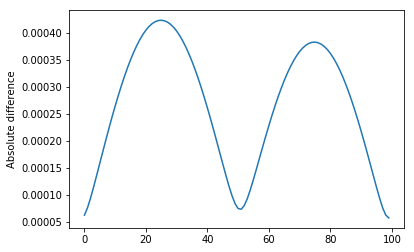

Testing y=0 and y=period


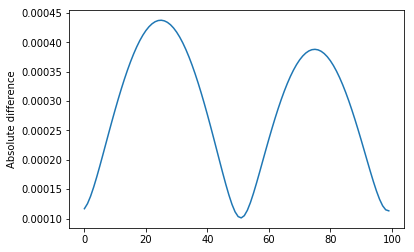

Testing x=0 and x=period


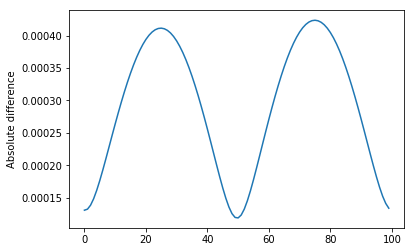

Testing y=0 and y=period


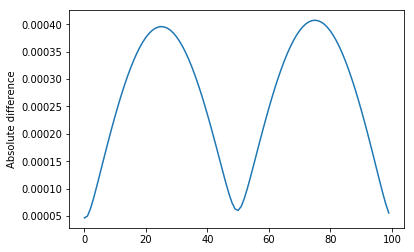

Testing x=0 and x=period


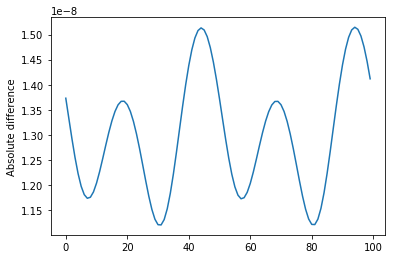

Testing y=0 and y=period


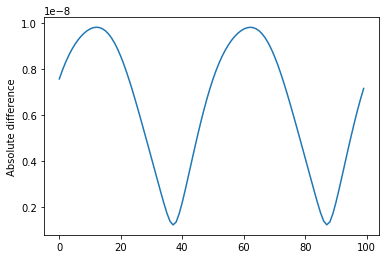

In [45]:
for component in (Explane, Eyplane, Ezplane):
    print('Testing x=0 and x=period')
    try:
        assert np.all(np.isclose(component[:, -1], component[:, 0]))
    except AssertionError:
        print('WARNING: Not periodic!')
        diff = np.absolute(component[:, -1] - component[:, 0])
        plt.figure()
        plt.plot(diff)
        plt.ylabel('Absolute difference')
        plt.show()
    print('Testing y=0 and y=period')
    try:
        assert np.all(np.isclose(component[:, -1], component[:, 0]))
    except AssertionError:
        print('WARNING: Not periodic!')
        diff = np.absolute(component[-1, :] - component[0, :])
        plt.figure()
        plt.plot(diff)
        plt.ylabel('Absolute difference')
        plt.show()

So these are not periodic. This could be because S4 excludes x=period when taking data at i=100 (think np.arange) so we haven't actually reached the periodic BC. Lets try explicitly getting the correct positions using `GetFieldsAtPoint` and see if data when x=0 and x=period are the same

In [46]:
vals = np.linspace(0, sim.period, 100)
xofields = 0j*np.zeros((len(vals), 3))
xpfields = 0j*np.zeros((len(vals), 3))
for i, val in enumerate(vals):
    xofield = sim.compute_fields_at_point(0, val, .6)
    xpfield = sim.compute_fields_at_point(sim.period, val, .6)
    xofields[i, 0] = xofield[0]
    xofields[i, 1] = xofield[1]
    xofields[i, 2] = xofield[2]
    xpfields[i, 0] = xpfield[0]
    xpfields[i, 1] = xpfield[1]
    xpfields[i, 2] = xpfield[2]

`np.isclose` compares fields elementwise and is True if the elements are the same within a tolerance, False
otherwise. `np.all` makes sure all elements are True. First column is x component of fields, second column y 
component, third column z component.

In [47]:
diff = np.absolute(xofields - xpfields)
assert np.all(np.isclose(xofields, xpfields))
print(diff)

[[  0.00000000e+00   0.00000000e+00   2.94902991e-17]
 [  0.00000000e+00   0.00000000e+00   2.94783386e-17]
 [  0.00000000e+00   0.00000000e+00   2.96936829e-17]
 [  0.00000000e+00   0.00000000e+00   2.99239800e-17]
 [  0.00000000e+00   0.00000000e+00   3.15635070e-17]
 [  0.00000000e+00   0.00000000e+00   3.07179561e-17]
 [  0.00000000e+00   0.00000000e+00   2.16840434e-17]
 [  0.00000000e+00   0.00000000e+00   2.94902991e-17]
 [  0.00000000e+00   0.00000000e+00   2.44251283e-17]
 [  0.00000000e+00   0.00000000e+00   2.25514052e-17]
 [  0.00000000e+00   0.00000000e+00   2.86229374e-17]
 [  0.00000000e+00   0.00000000e+00   2.34187669e-17]
 [  0.00000000e+00   0.00000000e+00   3.03576608e-17]
 [  0.00000000e+00   0.00000000e+00   2.16840434e-17]
 [  0.00000000e+00   0.00000000e+00   2.25514052e-17]
 [  0.00000000e+00   0.00000000e+00   2.64794046e-17]
 [  0.00000000e+00   0.00000000e+00   2.25514052e-17]
 [  0.00000000e+00   0.00000000e+00   2.25514052e-17]
 [  0.00000000e+00   0.00000

So these seem periodic! This is good news. Double checking in the y direction just in case.

In [48]:
vals = np.linspace(0, sim.period, 100)
xofields = 0j*np.zeros((len(vals), 3))
xpfields = 0j*np.zeros((len(vals), 3))
for i, val in enumerate(vals):
    xofield = sim.compute_fields_at_point(val, 0, .6)
    xpfield = sim.compute_fields_at_point(val, sim.period, .6)
    xofields[i, 0] = xofield[0]
    xofields[i, 1] = xofield[1]
    xofields[i, 2] = xofield[2]
    xpfields[i, 0] = xpfield[0]
    xpfields[i, 1] = xpfield[1]
    xpfields[i, 2] = xpfield[2]
diff = np.absolute(xofields - xpfields)
assert np.all(np.isclose(xofields, xpfields))
print(diff)

[[  0.00000000e+00   0.00000000e+00   2.68882139e-17]
 [  0.00000000e+00   0.00000000e+00   2.77153654e-17]
 [  0.00000000e+00   0.00000000e+00   2.68882139e-17]
 [  0.00000000e+00   0.00000000e+00   2.81867544e-17]
 [  0.00000000e+00   0.00000000e+00   2.79724161e-17]
 [  0.00000000e+00   0.00000000e+00   2.66713734e-17]
 [  0.00000000e+00   0.00000000e+00   2.77691248e-17]
 [  0.00000000e+00   0.00000000e+00   2.73218947e-17]
 [  0.00000000e+00   0.00000000e+00   2.73218947e-17]
 [  0.00000000e+00   0.00000000e+00   2.69301503e-17]
 [  0.00000000e+00   0.00000000e+00   2.68882139e-17]
 [  0.00000000e+00   0.00000000e+00   3.02583714e-17]
 [  0.00000000e+00   0.00000000e+00   2.68882139e-17]
 [  0.00000000e+00   0.00000000e+00   2.79715756e-17]
 [  0.00000000e+00   0.00000000e+00   2.68882139e-17]
 [  0.00000000e+00   0.00000000e+00   2.60208521e-17]
 [  0.00000000e+00   0.00000000e+00   2.25514052e-17]
 [  0.00000000e+00   0.00000000e+00   2.25514052e-17]
 [  0.00000000e+00   0.00000

Good, so we know things are periodic! In this case, the last column of values from `GetFieldsOnPlane` should be 
equal to the fields returned by `GetFieldsAtPoint` with y=period-dy. I verify this below

[-0.00061001-0.00554757j -0.00683295-0.00603742j -0.01302798-0.00652409j
 -0.01917063-0.00700559j -0.02523663-0.00747998j -0.03120203-0.00794531j
 -0.03704328-0.00839971j -0.04273729-0.00884134j -0.04826158-0.00926841j
 -0.05359434-0.00967921j -0.05871450-0.01007208j -0.06360184-0.01044545j
 -0.06823706-0.01079784j -0.07260185-0.01112785j -0.07667899-0.01143417j
 -0.08045237-0.01171562j -0.08390711-0.01197108j -0.08702955-0.01219959j
 -0.08980739-0.01240026j -0.09222966-0.01257234j -0.09428681-0.01271519j
 -0.09597073-0.0128283j  -0.09727479-0.01291127j -0.09819385-0.01296383j
 -0.09872430-0.01298582j -0.09886407-0.01297721j -0.09861262-0.01293811j
 -0.09797097-0.01286872j -0.09694167-0.01276937j -0.09552882-0.0126405j
 -0.09373799-0.01248269j -0.09157630-0.0122966j  -0.08905229-0.01208301j
 -0.08617594-0.0118428j  -0.08295863-0.01157695j -0.07941307-0.01128654j
 -0.07555328-0.01097273j -0.07139449-0.01063677j -0.06695314-0.01028j
 -0.06224675-0.00990383j -0.05729392-0.00950972j -0.052

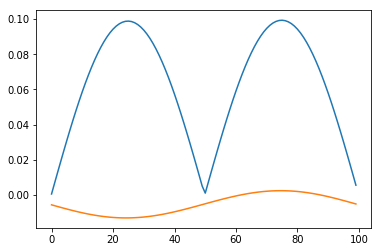

AssertionError: 

In [49]:
dy = sim.period/num_samples
# This excludes x=period
yvals = np.arange(0, sim.period, dy)
Expoint = 0j*np.zeros((len(vals),))
Eypoint = 0j*np.zeros((len(vals),))
Ezpoint = 0j*np.zeros((len(vals),))
for i, val in enumerate(yvals):
    ex, ey, ez = sim.compute_fields_at_point(val, sim.period-dy, .6)
    Expoint[i] = ex
    Eypoint[i] = ey
    Ezpoint[i] = ez
xdiff = Explane[:, -1] - Expoint
ydiff = Eyplane[:, -1] - Eypoint
zdiff = Ezplane[:, -1] - Ezpoint
assert np.all(np.isclose(Expoint, Explane[:, -1]))
assert np.all(np.isclose(Eypoint, Eyplane[:, -1]))
print(zdiff)
plt.figure()
plt.plot(abs(zdiff.real))
plt.plot(zdiff.imag)
plt.show()
assert np.all(np.isclose(Ezpoint, Ezplane[:, -1]))

So strangely, the x and y components of the E field pass this test. The z component of the field does not! This 
seems like a bug in S4 somewhere, either in S4 itself or in the Python interface. Not sure I have the time or desire
to debug this further, and may just stop using the `GetFieldsOnPlane` function. The problem with this is that the
`GetFieldAtPoint` function is much less efficient, and will probably be considerably slower. I test this claim
below.

In [50]:
def test_by_point(sim, z, xsamp, ysamp):
    dx = sim.period/xsamp
    dy = sim.period/ysamp
    Ex = 0j*np.zeros((xsamp, ysamp))
    Ey = 0j*np.zeros((xsamp, ysamp))
    Ez = 0j*np.zeros((xsamp, ysamp))
    xcoords = np.arange(0, sim.period, dx)
    ycoords = np.arange(0, sim.period, dy)
    for i, x in enumerate(xcoords):
        for j, y in enumerate(ycoords):
            E = sim.compute_fields_at_point(x, y, z) 
            Ex[i, j] = E[0]
            Ey[i, j] = E[1]
            Ez[i, j] = E[2]
    return (Ex, Ey, Ez)


def test_by_point_vec(sim, z, xsamp, ysamp):
    dx = sim.period/xsamp
    dy = sim.period/ysamp
    Ex = 0j*np.zeros((xsamp, ysamp))
    Ey = 0j*np.zeros((xsamp, ysamp))
    Ez = 0j*np.zeros((xsamp, ysamp))
    xcoords = np.arange(0, sim.period, dx)
    ycoords = np.arange(0, sim.period, dy)
    xx, yy = np.meshgrid(xcoords, ycoords)
    test = np.vectorize(sim.compute_fields_at_point)
    return test(xx, yy, z)

In [51]:
Epoint = test_by_point(sim, .6, 100, 100)
Eplane = sim.compute_fields_on_plane(.6, 100, 100)
print('Done!')

Done!


In [52]:
comps = ('Ex', 'Ey', 'Ez')
for i in range(len(Epoint)):
    diff = np.absolute(Epoint[i] - Eplane[i])
    try:
        assert np.all(np.isclose(Epoint[i], Eplane[i])) 
    except AssertionError:
        print("{} component not the same!".format(comps[i]))
        print(diff)

Ez component not the same!
[[ 0.00129677  0.00708476  0.01326459 ...,  0.0179111   0.01175142
   0.005581  ]
 [ 0.00733153  0.01011292  0.01509831 ...,  0.01929921  0.01378211
   0.0091181 ]
 [ 0.01352845  0.01521471  0.01889318 ...,  0.02238101  0.01785563
   0.01457024]
 ..., 
 [ 0.01761846  0.01893384  0.02198782 ...,  0.02507089  0.02113199
   0.0184374 ]
 [ 0.01144832  0.01339259  0.0174575  ...,  0.02121051  0.01635371
   0.01267256]
 [ 0.00525352  0.00872006  0.01420217 ...,  0.01862142  0.01280904
   0.00755717]]


## Nanowire

In [53]:
num_samples = 100
Explane, Eyplane, Ezplane = sim.compute_fields_on_plane(1.0, num_samples, num_samples)

Testing x=0 and x=period


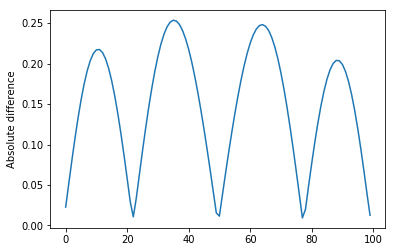

Testing y=0 and y=period


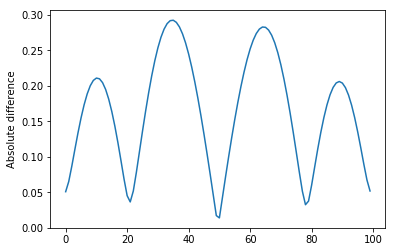

Testing x=0 and x=period


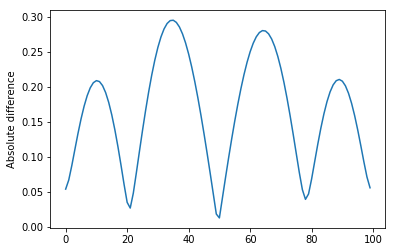

Testing y=0 and y=period


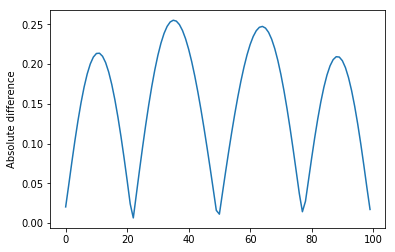

Testing x=0 and x=period


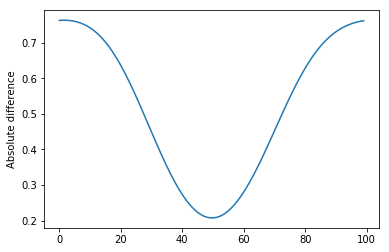

Testing y=0 and y=period


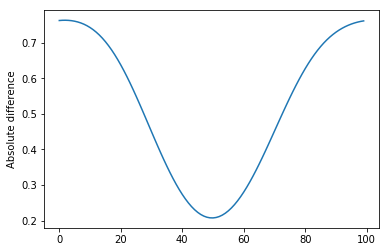

In [54]:
comps = ('Ex', 'Ey', 'Ez')
for i, component in enumerate((Explane, Eyplane, Ezplane)):
    print('Testing x=0 and x=period')
    try:
        assert np.all(np.isclose(component[:, -1], component[:, 0]))
    except AssertionError:
        print('WARNING: {} component not periodic!'.format(comps[i]))
        diff = np.absolute(component[:, -1] - component[:, 0])
        plt.figure()
        plt.plot(diff)
        plt.ylabel('Absolute difference')
        plt.show()
    print('Testing y=0 and y=period')
    try:
        assert np.all(np.isclose(component[:, -1], component[:, 0]))
    except AssertionError:
        print('WARNING: {} component not periodic!'.format(comps[i]))
        diff = np.absolute(component[-1, :] - component[0, :])
        plt.figure()
        plt.plot(diff)
        plt.ylabel('Absolute difference')
        plt.show()

In [55]:
vals = np.linspace(0, sim.period, 100)
xofields = 0j*np.zeros((len(vals), 3))
xpfields = 0j*np.zeros((len(vals), 3))
for i, val in enumerate(vals):
    xofield = sim.compute_fields_at_point(0, val, 1.0)
    xpfield = sim.compute_fields_at_point(sim.period, val, 1.0)
    xofields[i, 0] = xofield[0]
    xofields[i, 1] = xofield[1]
    xofields[i, 2] = xofield[2]
    xpfields[i, 0] = xpfield[0]
    xpfields[i, 1] = xpfield[1]
    xpfields[i, 2] = xpfield[2]
diff = np.absolute(xofields - xpfields)
assert np.all(np.isclose(xofields, xpfields))
print(diff)

[[  8.88178420e-16   3.55271368e-15   3.10484489e-15]
 [  3.55271368e-15   8.88178420e-16   2.99965743e-15]
 [  7.10542736e-15   8.88178420e-16   3.07072516e-15]
 [  3.55271368e-15   7.10542736e-15   2.39149358e-15]
 [  3.66205344e-15   3.55271368e-15   3.28032861e-15]
 [  3.58036167e-15   3.66205344e-15   2.67377111e-15]
 [  3.58036167e-15   7.32410688e-15   3.02013315e-15]
 [  3.66205344e-15   7.11929162e-15   4.37377148e-15]
 [  4.44089210e-16   3.66205344e-15   4.09430021e-15]
 [  3.97205465e-15   0.00000000e+00   3.55271368e-15]
 [  3.97205465e-15   1.98602732e-15   3.76822190e-15]
 [  3.58036167e-15   1.98602732e-15   3.20237283e-15]
 [  1.33226763e-15   8.88178420e-16   1.98602732e-15]
 [  3.97205465e-15   4.44089210e-16   2.22044605e-15]
 [  3.58036167e-15   3.10862447e-15   3.20237283e-15]
 [  2.51214793e-15   3.58036167e-15   2.22044605e-15]
 [  1.77635684e-15   3.55271368e-15   1.33226763e-15]
 [  3.79429987e-15   8.88178420e-16   1.33226763e-15]
 [  3.97205465e-15   8.88178

In [56]:
vals = np.linspace(0, sim.period, 100)
xofields = 0j*np.zeros((len(vals), 3))
xpfields = 0j*np.zeros((len(vals), 3))
for i, val in enumerate(vals):
    xofield = sim.compute_fields_at_point(val, 0, 1.0)
    xpfield = sim.compute_fields_at_point(val, sim.period, 1.0)
    xofields[i, 0] = xofield[0]
    xofields[i, 1] = xofield[1]
    xofields[i, 2] = xofield[2]
    xpfields[i, 0] = xpfield[0]
    xpfields[i, 1] = xpfield[1]
    xpfields[i, 2] = xpfield[2]
diff = np.absolute(xofields - xpfields)
assert np.all(np.isclose(xofields, xpfields))
print(diff)

[[  8.88178420e-16   3.97205465e-15   3.14705422e-15]
 [  3.66205344e-15   8.88178420e-16   3.06117702e-15]
 [  3.55271368e-15   8.88178420e-16   3.50424447e-15]
 [  1.77635684e-15   3.97205465e-15   3.38936379e-15]
 [  1.33226763e-15   3.55271368e-15   3.58724038e-15]
 [  7.32410688e-15   3.66205344e-15   4.37940416e-15]
 [  4.44089210e-16   3.55271368e-15   3.87784231e-15]
 [  4.44089210e-16   8.88178420e-16   2.59896547e-15]
 [  8.88178420e-16   0.00000000e+00   3.44705924e-15]
 [  1.83102672e-15   8.88178420e-16   3.55271368e-15]
 [  2.22044605e-15   3.97205465e-15   4.80355925e-15]
 [  3.55271368e-15   3.79429987e-15   3.55271368e-15]
 [  5.40257841e-15   1.77635684e-15   2.84355838e-15]
 [  2.51214793e-15   3.97205465e-15   6.16948447e-15]
 [  1.77635684e-15   1.98602732e-15   3.58036167e-15]
 [  1.77635684e-15   3.20237283e-15   3.58036167e-15]
 [  1.77635684e-15   4.44089210e-16   3.20237283e-15]
 [  1.98602732e-15   1.83102672e-15   3.20237283e-15]
 [  3.58036167e-15   7.16072

[  4.10782519e-15 -1.83186799e-15j   4.21884749e-15 -2.66453526e-15j
   3.77475828e-15 +6.66133815e-16j   1.75554016e-15 -5.77315973e-15j
   6.10622664e-15 +8.88178420e-16j   3.71924713e-15 -4.44089210e-15j
   3.99680289e-15 -1.77635684e-15j   3.44169138e-15 -8.88178420e-16j
   1.33226763e-15 -5.32907052e-15j   4.66293670e-15 +0.00000000e+00j
   1.99840144e-15 -2.66453526e-15j   5.55111512e-15 -1.77635684e-15j
   4.44089210e-15 -1.77635684e-15j   1.77635684e-15 -8.88178420e-15j
   5.32907052e-15 -1.77635684e-15j   0.00000000e+00 -1.77635684e-15j
   4.44089210e-16 -3.55271368e-15j   4.88498131e-15 -3.55271368e-15j
  -4.44089210e-15 -5.32907052e-15j   2.22044605e-15 -1.77635684e-15j
  -1.33226763e-15 -1.77635684e-15j   3.10862447e-15 -3.55271368e-15j
   4.88498131e-15 -5.32907052e-15j  -4.44089210e-15 -5.32907052e-15j
   1.77635684e-15 -5.32907052e-15j   2.66453526e-15 -5.32907052e-15j
   2.66453526e-15 -7.10542736e-15j   4.44089210e-15 -7.10542736e-15j
  -2.66453526e-15 -3.55271368e-15j

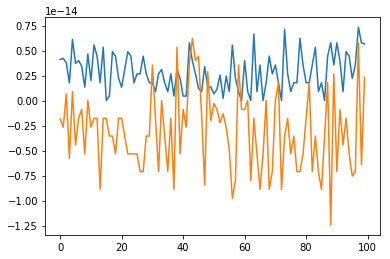

In [57]:
dy = sim.period/num_samples
# This excludes x=period
yvals = np.arange(0, sim.period, dy)
Expoint = 0j*np.zeros((len(vals),))
Eypoint = 0j*np.zeros((len(vals),))
Ezpoint = 0j*np.zeros((len(vals),))
for i, val in enumerate(yvals):
    ex, ey, ez = sim.compute_fields_at_point(val, sim.period-dy, 1.0)
    Expoint[i] = ex
    Eypoint[i] = ey
    Ezpoint[i] = ez
xdiff = Explane[:, -1] - Expoint
ydiff = Eyplane[:, -1] - Eypoint
zdiff = Ezplane[:, -1] - Ezpoint
assert np.all(np.isclose(Expoint, Explane[:, -1]))
assert np.all(np.isclose(Eypoint, Eyplane[:, -1]))
print(zdiff)
plt.figure()
plt.plot(abs(zdiff.real))
plt.plot(zdiff.imag)
plt.show()
assert np.all(np.isclose(Ezpoint, Ezplane[:, -1]))

In [58]:
Epoint = test_by_point(sim, 1.0, 100, 100)
Eplane = sim.compute_fields_on_plane(1.0, 100, 100)
print('Done!')

Done!


In [59]:
comps = ('Ex', 'Ey', 'Ez')
for i in range(len(Epoint)):
    diff = np.absolute(Epoint[i] - Eplane[i])
    try:
        assert np.all(np.isclose(Epoint[i], Eplane[i])) 
    except AssertionError:
        print("{} component not the same!".format(comps[i]))
        print(diff)
        raise
print('All components agree!')

All components agree!


So the results are the same with a nanowire centered on the origin. This is good news at least.